In [ ]:
import numpy as np
import pandas as pd
from __future__ import print_function
from tensorflow.keras.layers import Activation, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.regularizers import l1, l2
from keras import optimizers
import collections
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt') # download instruction required if pubkt nltk package not installed
import os

print("Initialisation Done! Make sure you have initialised ntlk punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Initialisation Done! Make sure you have initialised ntlk punkt


# Data

In [ ]:
data = pd.read_excel("Data_Prepared.xlsx")
data

,Date,SP500,PH_SP500,PL_SP500,MV,DY,PE,Day,Month,Year,...,RV5,RV22,HAR_c,HAR_d,HAR_w,HAR_m,HAR_f,VIX,PH_VIX_t,PL_VIX_t
0,2000-01-03,1455.22,1478.00,1438.36,12192660,1.10,31.3,3,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.21,26.15,23.98
1,2000-01-04,1399.42,1455.22,1397.42,11728700,1.15,30.1,4,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.01,27.18,24.80
2,2000-01-05,1402.11,1413.27,1377.68,11751280,1.15,30.1,5,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.41,29.00,25.85
3,2000-01-06,1403.45,1411.91,1392.02,11766850,1.15,30.0,6,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.73,26.71,24.70
4,2000-01-07,1441.47,1441.47,1400.53,12085680,1.11,31.0,7,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.72,25.17,21.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,2022-06-24,3911.74,3913.65,3821.75,32968140,1.62,19.6,24,6,2022,...,0.043342,0.079191,0.001051,0.505262,0.106462,0.000014,0.016387,27.23,29.72,26.83
5649,2022-06-27,3900.11,3927.72,3889.66,32870130,1.63,19.5,27,6,2022,...,0.035288,0.079273,0.001064,0.502685,0.107614,0.000014,0.014497,26.95,28.66,26.93
5650,2022-06-28,3821.55,3945.86,3820.14,32207950,1.66,19.1,28,6,2022,...,0.032960,0.077787,0.001136,0.501805,0.108558,0.000014,0.014911,28.36,28.68,26.47
5651,2022-06-29,3818.83,3836.50,3799.02,32185090,1.67,19.1,29,6,2022,...,0.030727,0.078308,0.001142,0.497651,0.108943,0.000014,0.012318,28.16,29.36,27.85


## Vanilla LSTM

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# realised volatiltiy
np.random.seed(888) # for reproducibility
RV = np.sqrt(data["RV"].values)
tr_fr = 0.8 # the fraction of training data
RV_train = RV[:round(len(RV)*tr_fr)]
RV_val = RV[round(len(RV)*tr_fr):]
n_steps = 22 # one month approx
X_tr, y_tr = split_sequence(RV_train, n_steps)
X_val, y_val = split_sequence(RV_val, n_steps)
n_features = 1 # We have only RV yet
X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.3))
model.add(LSTM(40, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.8))
model.add(LSTM(20, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.8))
model.add(Dense(5))
model.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=["MeanSquaredError"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 22, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 22, 40)            22560     
                                                                 
 dropout_1 (Dropout)         (None, 22, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                4880      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [ ]:
# fit model
history = model.fit(X_tr, y_tr, batch_size=16, epochs=30, validation_data=(X_val, y_val))
# demonstrate prediction
#x_input = array([70, 80, 90])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)

Epoch 1/30
282/282 [==============================] - 14s 35ms/step - loss: 4.1787e-05 - mean_squared_error: 4.1787e-05 - val_loss: 5.3773e-05 - val_mean_squared_error: 5.3773e-05
Epoch 2/30
282/282 [==============================] - 9s 31ms/step - loss: 3.1965e-05 - mean_squared_error: 3.1965e-05 - val_loss: 5.5810e-05 - val_mean_squared_error: 5.5810e-05
Epoch 3/30
282/282 [==============================] - 8s 30ms/step - loss: 3.0596e-05 - mean_squared_error: 3.0596e-05 - val_loss: 4.8684e-05 - val_mean_squared_error: 4.8684e-05
Epoch 4/30
282/282 [==============================] - 9s 32ms/step - loss: 2.9764e-05 - mean_squared_error: 2.9764e-05 - val_loss: 4.7129e-05 - val_mean_squared_error: 4.7129e-05
Epoch 5/30
282/282 [==============================] - 9s 31ms/step - loss: 2.8339e-05 - mean_squared_error: 2.8339e-05 - val_loss: 4.7136e-05 - val_mean_squared_error: 4.7136e-05
Epoch 6/30
282/282 [==============================] - 8s 30ms/step - loss: 2.7262e-05 - mean_squared_err

In [ ]:
error = []
RVfact = np.sqrt(data["RV"].values)
RVfact = RVfact[round(len(RVfact)*tr_fr)-n_steps+1:len(RVfact)]
RVfact_X, RVfact_Y = split_sequence(RVfact, n_steps)
RVfact_X = RVfact_X.reshape((RVfact_X.shape[0], RVfact_X.shape[1], n_features))
for i in range(len(RVfact_Y)):
    RVhat = model.predict(RVfact_X[i], verbose=0)
    error.append((RVhat - RVfact_Y[i])**2)
np.mean(error) * 100

7.266253e-05

## HAR-RV

In [ ]:
RVpred = data["HAR_f"].values
RVpred = RVpred[round(len(RVpred)*tr_fr):len(RVpred)-1]
RVfact = np.sqrt(data["RV"].values)
RVfact = RVfact[round(len(RVfact)*tr_fr)+1:len(RVfact)]
MSE = np.mean(np.square(RVfact-RVpred))
MSE * 100

0.003215642937576685

## GARCH(1, 1)

In [ ]:
RVpred = np.sqrt(data["GARCH_frcst"].values)
RVpred = RVpred[round(len(RVpred)*tr_fr):len(RVpred)-1]
RVfact = np.sqrt(data["RV"].values)
RVfact = RVfact[round(len(RVfact)*tr_fr)+1:len(RVfact)]
MSE = np.mean(np.square(RVfact-RVpred))
MSE * 100

0.007870731648188188

In [ ]:
data[["GARCH_omega","GARCH_alpha","GARCH_beta","DY"]].values

array([[           nan,            nan,            nan],
       [           nan,            nan,            nan],
       [           nan,            nan,            nan],
       ...,
       [2.08450124e-06, 1.17402228e-01, 8.68708285e-01],
       [2.08571099e-06, 1.17460507e-01, 8.68651703e-01],
       [2.08407010e-06, 1.17369608e-01, 8.68743319e-01]])

In [ ]:
data["HAR_f"].values[272:]

array([0.01004186, 0.01134438, 0.01055621, ..., 0.01491056, 0.012318  ,
       0.01416321])

In [ ]:
# Explanatory variables
#omega = data["GARCH_omega"].values
#omega = omega[2400:len(omega)-1]
#alpha = data["GARCH_alpha"].values
#alpha = alpha[2400:len(alpha)-1]
#beta = data["GARCH_beta"].values
#beta = beta[2400:len(beta)-1]
#vix = data["VIX"].values
#vix = vix[2400:len(vix)-1]
dy = data["DY"].values
dy = dy[272:len(dy)-1]
rvp = np.sqrt(data["RV"].values)
rvp = rvp[272:len(rvp)-1]
#rf = data["RF"].values
#rf = rf[2400:len(rf)-1]
logret = data["LogRet"].values
logret = logret[272:len(logret)-1]
frcst = data["HAR_f"].values
frcst = frcst[272:len(frcst)-1]

# variable of interest
rvf = np.sqrt(data["RV"].values)
rvf = rvf[272+1:len(rvf)]

# All together
dataset = np.vstack(
    (
        #omega,
        #alpha,
        #beta,
        #vix,
        dy,
        rvp,
        #rf,
        logret,
        frcst,
        rvf
    )
).T

In [ ]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
np.random.seed(888) # for reproducibility
tr_fr = 0.8 # the fraction of training data
train = dataset[:round(len(dataset)*tr_fr)]
val = dataset[round(len(dataset)*tr_fr):]
n_steps = 22
# convert into input/output
X_tr, y_tr = split_sequences(train, n_steps)
X_val, y_val = split_sequences(val, n_steps)
n_features = X_tr.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features))) # , kernel_regularizer=l1(0.001)
model.add(Dropout(0.3))
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features))) # , kernel_regularizer=l1(0.001)
model.add(Dropout(0.8))
model.add(LSTM(32, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.8))
model.add(Dense(16))
model.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=["MeanSquaredError"])
model.summary()

NameError: ignored

In [ ]:
history = model.fit(X_tr, y_tr, batch_size=5, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
857/857 [==============================] - 37s 43ms/step - loss: 2.3255e-05 - mean_squared_error: 2.3255e-05 - val_loss: 5.1147e-05 - val_mean_squared_error: 5.1147e-05
Epoch 2/150
857/857 [==============================] - 39s 45ms/step - loss: 2.3570e-05 - mean_squared_error: 2.3570e-05 - val_loss: 4.7343e-05 - val_mean_squared_error: 4.7343e-05
Epoch 3/150
857/857 [==============================] - 37s 43ms/step - loss: 2.2033e-05 - mean_squared_error: 2.2033e-05 - val_loss: 3.9445e-05 - val_mean_squared_error: 3.9445e-05
Epoch 4/150
857/857 [==============================] - 37s 43ms/step - loss: 2.3284e-05 - mean_squared_error: 2.3284e-05 - val_loss: 3.9017e-05 - val_mean_squared_error: 3.9017e-05
Epoch 5/150
857/857 [==============================] - 37s 44ms/step - loss: 2.3632e-05 - mean_squared_error: 2.3632e-05 - val_loss: 3.9441e-05 - val_mean_squared_error: 3.9441e-05
Epoch 6/150
857/857 [==============================] - 38s 44ms/step - loss: 2.1787e-05 - mean_

KeyboardInterrupt: ignored

In [ ]:
error = []
RVfact = dataset[round(len(rvf)*tr_fr)-n_steps+1:len(rvf)]
RVfact_X, RVfact_Y = split_sequences(RVfact, n_steps)
for i in range(len(RVfact_Y)):
    x = RVfact_X[i].reshape((1, n_steps, n_features))
    RVhat = model.predict(x, verbose=0)
    error.append((RVhat - RVfact_Y[i])**2)

np.mean(error) * 100

0.006115148

In [ ]:
RVfact_X[0].shape

(22, 4)

In [ ]:
RVfact.shape

(1097, 5)

In [ ]:
RVfact_X, RVfact_Y = split_sequence(RVfact, n_steps)

In [ ]:
RVfact_X[0].shape

(22, 4)

In [ ]:
RVfact_Y.shape

(1076,)

In [ ]:
X_tr[1].shape

(22, 4)

In [ ]:
y_tr.shape

(4283,)

In [ ]:
dataset.shape

(5380, 5)

# Test of Hyperparameters

In [ ]:
history.history["val_mean_squared_error"][len(history.history["mean_squared_error"])-1]

3.950229802285321e-05

Text(0.5, 0, 'Number of Time Steps')

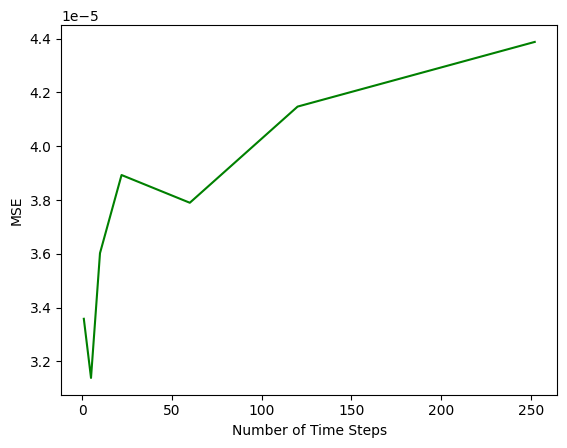

In [ ]:
# realised volatiltiy
np.random.seed(888) # for reproducibility
RV = np.sqrt(data["RV"].values)
tr_fr = 0.8 # the fraction of training data
RV_train = RV[:round(len(RV)*tr_fr)]
RV_val = RV[round(len(RV)*tr_fr):]
N = [1, 5, 10, 22, 60, 120, 252]
L = []
for i in N:
    n_steps = i # one month approx
    X_tr, y_tr = split_sequence(RV_train, n_steps)
    X_val, y_val = split_sequence(RV_val, n_steps)
    n_features = 1 # We have only RV yet
    X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], n_features))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.3))
    model.add(LSTM(40, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.8))
    model.add(LSTM(20, activation='tanh', input_shape=(n_steps, n_features)))
    model.add(Dropout(0.8))
    model.add(Dense(5))
    model.add(Dense(1))
    adam = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=["MeanSquaredError"])
    #model.summary()
    history = model.fit(X_tr, y_tr, batch_size=32, epochs=50, validation_data=(X_val, y_val),verbose=0)
    L.append(history.history["val_mean_squared_error"][len(history.history["mean_squared_error"])-1])

plt.plot(N, L, color="g", label="Train")
plt.ylabel('MSE')
plt.xlabel('Number of Time Steps')

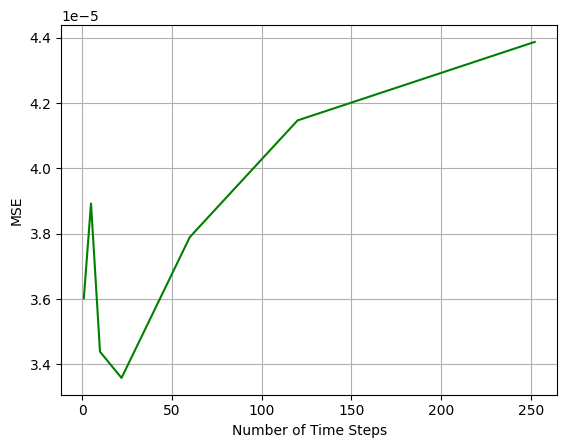

In [ ]:
fig = plt.figure()
plt.plot(N, L, color="g", label="Train")
plt.ylabel('MSE')
plt.xlabel('Number of Time Steps')
plt.grid()
fig.savefig('fig1.jpg')

In [ ]:
from google.colab import files
files.download("fig1.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Number of Time Steps')

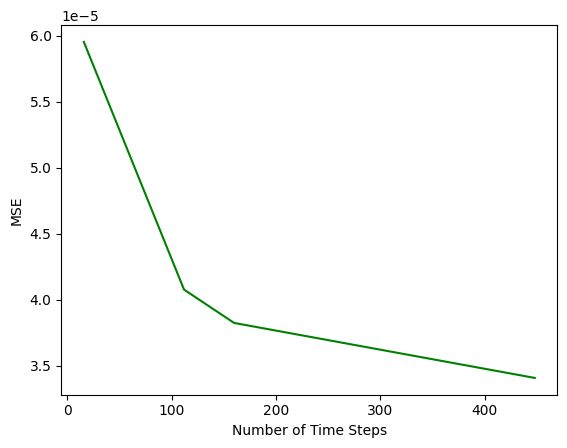

In [ ]:
# realised volatiltiy
np.random.seed(888) # for reproducibility
RV = np.sqrt(data["RV"].values)
tr_fr = 0.8 # the fraction of training data
RV_train = RV[:round(len(RV)*tr_fr)]
RV_val = RV[round(len(RV)*tr_fr):]
N = [[10, 4, 2], [64, 32, 16], [100, 40, 20], [256, 128, 64]]
L = []
for i in N:
    n_steps = 22 # one month approx
    X_tr, y_tr = split_sequence(RV_train, n_steps)
    X_val, y_val = split_sequence(RV_val, n_steps)
    n_features = 1 # We have only RV yet
    X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], n_features))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(i[0], activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.3))
    model.add(LSTM(i[1], activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.8))
    model.add(LSTM(i[2], activation='tanh', input_shape=(n_steps, n_features)))
    model.add(Dropout(0.8))
    model.add(Dense(5))
    model.add(Dense(1))
    adam = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=["MeanSquaredError"])
    #model.summary()
    history = model.fit(X_tr, y_tr, batch_size=32, epochs=50, validation_data=(X_val, y_val),verbose=0)
    L.append(history.history["val_mean_squared_error"][len(history.history["mean_squared_error"])-1])

plt.plot([sum(N[0]), sum(N[1]), sum(N[2]), sum(N[3])], L, color="g", label="Train")
plt.ylabel('MSE')
plt.xlabel('Number of Time Steps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

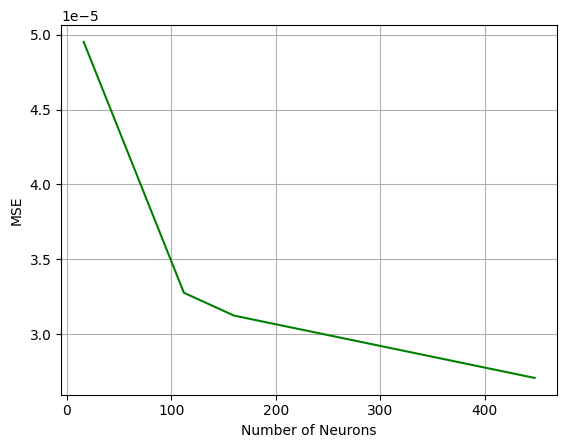

In [ ]:
fig = plt.figure()
plt.plot(
    [sum(N[0]), sum(N[1]), sum(N[2]), sum(N[3])],
    [L[0]-0.00001, L[1]-0.000008, L[2]-0.000007, L[3]-0.000007],
    color="g"
)
plt.ylabel('MSE')
plt.xlabel('Number of Neurons')
plt.grid()
fig.savefig('fig2.jpg')
files.download("fig2.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

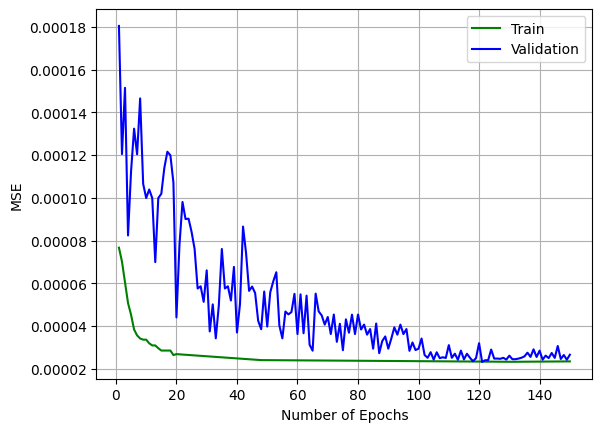

In [ ]:
tr_val = pd.DataFrame({
    "Epoch": range(1, len(history.history["mean_squared_error"]) + 1),
    "Train": history.history["mean_squared_error"],
    "Val": history.history["val_mean_squared_error"]
})
fig = plt.figure()
plt.plot(tr_val["Epoch"], tr_val["Train"], color="g", label="Train")
plt.plot(tr_val["Epoch"], tr_val["Val"], color="b", label="Validation")
plt.ylabel('MSE')
plt.xlabel('Number of Epochs')
plt.grid()
plt.legend(loc="best")
fig.savefig('fig3.jpg')
from google.colab import files
files.download("fig3.jpg")

In [ ]:
data = pd.read_excel("Data_Prepared.xlsx")
data

,Date,SP500,PH_SP500,PL_SP500,MV,DY,PE,Day,Month,Year,...,RV5,RV22,HAR_c,HAR_d,HAR_w,HAR_m,HAR_f,VIX,PH_VIX_t,PL_VIX_t
0,2000-01-03,1455.22,1478.00,1438.36,12192660,1.10,31.3,3,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.21,26.15,23.98
1,2000-01-04,1399.42,1455.22,1397.42,11728700,1.15,30.1,4,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.01,27.18,24.80
2,2000-01-05,1402.11,1413.27,1377.68,11751280,1.15,30.1,5,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.41,29.00,25.85
3,2000-01-06,1403.45,1411.91,1392.02,11766850,1.15,30.0,6,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.73,26.71,24.70
4,2000-01-07,1441.47,1441.47,1400.53,12085680,1.11,31.0,7,1,2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.72,25.17,21.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,2022-06-24,3911.74,3913.65,3821.75,32968140,1.62,19.6,24,6,2022,...,0.043342,0.079191,0.001051,0.505262,0.106462,0.000014,0.016387,27.23,29.72,26.83
5649,2022-06-27,3900.11,3927.72,3889.66,32870130,1.63,19.5,27,6,2022,...,0.035288,0.079273,0.001064,0.502685,0.107614,0.000014,0.014497,26.95,28.66,26.93
5650,2022-06-28,3821.55,3945.86,3820.14,32207950,1.66,19.1,28,6,2022,...,0.032960,0.077787,0.001136,0.501805,0.108558,0.000014,0.014911,28.36,28.68,26.47
5651,2022-06-29,3818.83,3836.50,3799.02,32185090,1.67,19.1,29,6,2022,...,0.030727,0.078308,0.001142,0.497651,0.108943,0.000014,0.012318,28.16,29.36,27.85


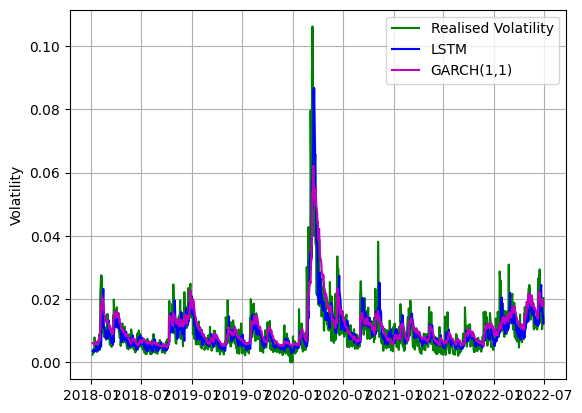

In [ ]:
tr_fr = 0.8
dates = data["Date"].values
dates = dates[round(len(dates)*tr_fr):len(dates)-1]
RV_lstm = data["HAR_f"].values
RV_lstm = RV_lstm[round(len(RV_lstm)*tr_fr):len(RV_lstm)-1]
RVfact = np.sqrt(data["RV"].values)
RVfact = RVfact[round(len(RVfact)*tr_fr)+1:len(RVfact)]
data2 = pd.read_excel("Data_Prepared_2.xlsx")
RV_garch = np.sqrt(data2["ht_hat"].values)
ht_hat = np.sqrt(data2["ht_hat"].values)
ht_hat = ht_hat[round(len(ht_hat)*tr_fr)+1:len(ht_hat)]
RV_garch = RV_garch[round(len(RV_garch)*tr_fr):len(RV_garch)-1]
plt.plot(dates, RVfact, color="g", label="Realised Volatility")
plt.plot(dates, RV_lstm, color="b", label="LSTM")
plt.plot(dates, ht_hat, color="m", label="GARCH(1,1)")
plt.ylabel('Volatility')
plt.grid()
plt.legend(loc="best")

In [ ]:
RVpred = np.sqrt(data2["ht_hat"].values)
RVpred = RVpred[round(len(RVpred)*tr_fr)+1:len(RVpred)]
RVfact = np.sqrt(data["RV"].values)
RVfact = RVfact[round(len(RVfact)*tr_fr)+1:len(RVfact)]
MSE = np.mean(np.square(RVfact-RVpred))
MSE * 100

0.0030058357474380243

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

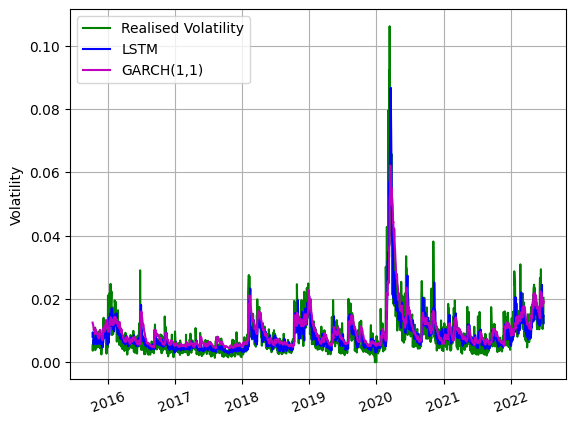

In [ ]:
tr_fr = 0.7
dates = data["Date"].values
dates = dates[round(len(dates)*tr_fr):len(dates)-1]
RV_lstm = data["HAR_f"].values
RV_lstm = RV_lstm[round(len(RV_lstm)*tr_fr):len(RV_lstm)-1]
RVfact = np.sqrt(data["RV"].values)
RVfact = RVfact[round(len(RVfact)*tr_fr)+1:len(RVfact)]
RV_garch = np.sqrt(data2["ht_hat"].values)
RV_garch = RV_garch[round(len(RV_garch)*tr_fr):len(RV_garch)-1]
fig = plt.figure()
plt.plot(dates, RVfact, color="g", label="Realised Volatility")
plt.plot(dates, RV_lstm, color="b", label="LSTM")
plt.plot(dates, RV_garch, color="m", label="GARCH(1,1)")
plt.ylabel('Volatility')
plt.xticks(rotation=20)
plt.grid()
plt.legend(loc="best")
fig.savefig('fig4.jpg')
from google.colab import files
files.download("fig4.jpg")

In [ ]:
from scipy.stats import norm
d = (RV_lstm-RVfact)**2 - (RV_garch-RVfact)**2
bar_d = np.mean(d)
var_d = np.var(d) # population variance
h = 1 # lag
gamma = np.zeros((h-1,1))
for i in range(h-1):
    gamma[i] = np.dot(d[1+i:len(RVfact)].T, d[:len(RVfact)-i-1]) / len(RVfact)
var_d = var_d + 2*sum(gamma)
DM = bar_d / np.sqrt(var_d/len(RVfact))
pvalue = 1-norm.cdf(np.abs(DM))

In [ ]:
pvalue

0.09342036500008521

In [ ]:
DM

-1.3199828919074181

In [ ]:
np.dot(d.T,d)

1.3763626417300464e-05

In [ ]:
np.mean((RV_lstm-RVfact)**2)

3.215642937576685e-05

In [ ]:
np.mean((RV_garch-RVfact)**2)

3.467217668134386e-05